In [1]:
import math
import torch
from utils import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import joblib

In [2]:
df = fetch_data()
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


### __Random Forest Regressor__

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(df)

In [13]:
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

In [14]:
# trained on 1/100th of the data
pipeline = Pipeline([
    ('model', RandomForestRegressor())
], verbose=1)

pipeline.fit(X_train_small, y_train_small["responder_6"]);

[Pipeline] ............. (step 1 of 1) Processing model, total= 2.4min


In [15]:
joblib.dump(pipeline, "models/pipeline.pkl")

['models/pipeline.pkl']

In [16]:
# run this cell to load model from file
pipeline = joblib.load("models/pipeline.pkl")

In [17]:
y_pred = pipeline.predict(X_test)

weights = torch.tensor(y_test['weight'].values)
y_true = torch.tensor(y_test['responder_6'].values)
y_pred = torch.tensor(y_pred)
numerator = torch.sum(weights * (y_true - y_pred) ** 2)
denominator = torch.sum(weights * y_true ** 2)
r2 = (numerator / denominator)
print(f'R^2 Loss: {r2.item()}')

R^2 Loss: 0.9992724208142942


### __MLP (Multi Layer Perceptron)__
- `Context`: `5` __time steps__

- `Input`: `79` __features__ $\times$ `5` __time steps__ = `395` __features__
- `Output`: __Responder 6__
- `Model`: `3` __hidden layers__ with `256`, `128`, `64` __neurons__
- `Activation`: __TanH__
- `Loss`: __Weighted Zero-Mean R-squared Score ($R^2$)__

$$
  R^2 = 1 - \frac{\sum w_i (y_i - \hat{y}_i)^2}{\sum w_i y_i^2}
$$



In [3]:
context = 5
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(df, context=context)

In [4]:
X_train.shape

(1749789, 398)

In [5]:
input = torch.tensor(X_train.drop(columns=['date_id', 'time_id', 'symbol_id']).values, dtype=torch.float32)
W1 = torch.randn((79 * context, 256))
b1 = torch.randn(256)
W2 = torch.randn((256, 128))
b2 = torch.randn(128)
W3 = torch.randn((128, 64))
b3 = torch.randn(64)
W4 = torch.randn((64, 1))
b4 = torch.randn(1)

parameters = [W1, b1, W2, b2, W3, b3, W4, b4]

In [6]:
for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters)

142593

In [8]:
lossi = []
lri = []

In [9]:
lrs = [1e-3, 1e-3, 1e-3, 1e-4, 1e-4, 1e-5, 1e-5]

In [10]:
for i in range(len(lrs) * 10000):

    # forward pass
    ix = torch.randint(0, input.shape[0], (64,))

    h1 = torch.tanh(input[ix] @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    h3 = torch.tanh(h2 @ W3 + b3)
    output = h3 @ W4 + b4

    # R^2 loss calculation
    weights = torch.tensor(y_train['weight'].values)[ix]
    y_true = torch.tensor(y_train['responder_6'].values)[ix]
    output = output.squeeze()
    numerator = torch.sum(weights * (y_true - output) ** 2)
    denominator = torch.sum(weights * y_true ** 2)
    loss = (numerator / denominator)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i // 10000]
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())
    lri.append(lr)

    print(f'Step {len(lri):5d} of {len(lrs) * 10000} - R^2 Loss: {loss.item()}', end="\r")

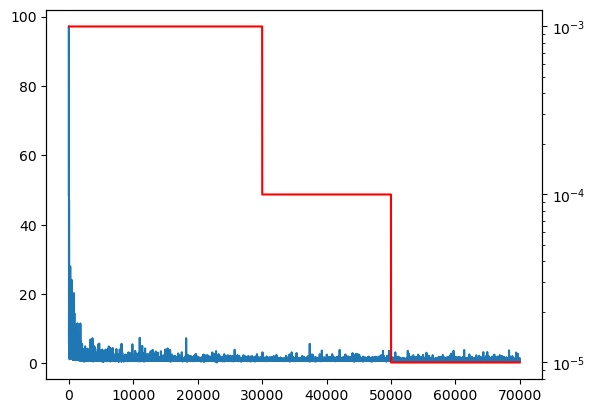

In [11]:
plt.plot(lossi)
alt = plt.twinx()
alt.plot(lri, color='red')
alt.set_yscale('log')

In [12]:
val_input = torch.tensor(X_val.drop(columns=['date_id', 'time_id', 'symbol_id']).values, dtype=torch.float32)

h1 = torch.tanh(val_input @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
h3 = torch.tanh(h2 @ W3 + b3)
output = h3 @ W4 + b4

r2_loss(y_val, output)

-0.02662944793701172